Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


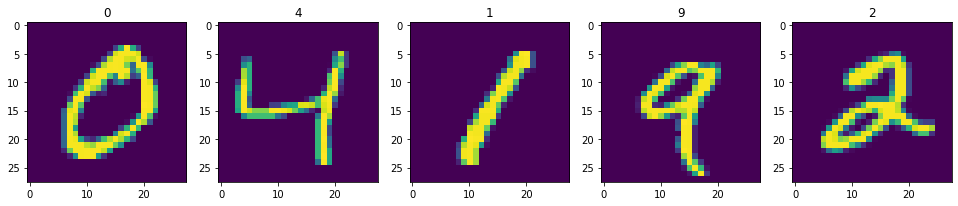


Epoch: 1/10, Train Loss: 0.30790325, Val Loss: 0.06140714, Val Accuracy: 0.97977778
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.06140714

Epoch: 2/10, Train Loss: 0.11386590, Val Loss: 0.04145493, Val Accuracy: 0.98500000
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.04145493

Epoch: 3/10, Train Loss: 0.08097234, Val Loss: 0.03550169, Val Accuracy: 0.98744444
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03550169

Epoch: 4/10, Train Loss: 0.06838852, Val Loss: 0.03339634, Val Accuracy: 0.98944444
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.03339634

Epoch: 5/10, Train Loss: 0.05951953, Val Loss: 0.02918131, Val Accuracy: 0.99100000
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02918131

Epoch: 6/10, Train Loss: 0.05192802, Val Loss: 0.02683332, Val Accuracy: 0.99177778
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.02683332

Epoch: 7/

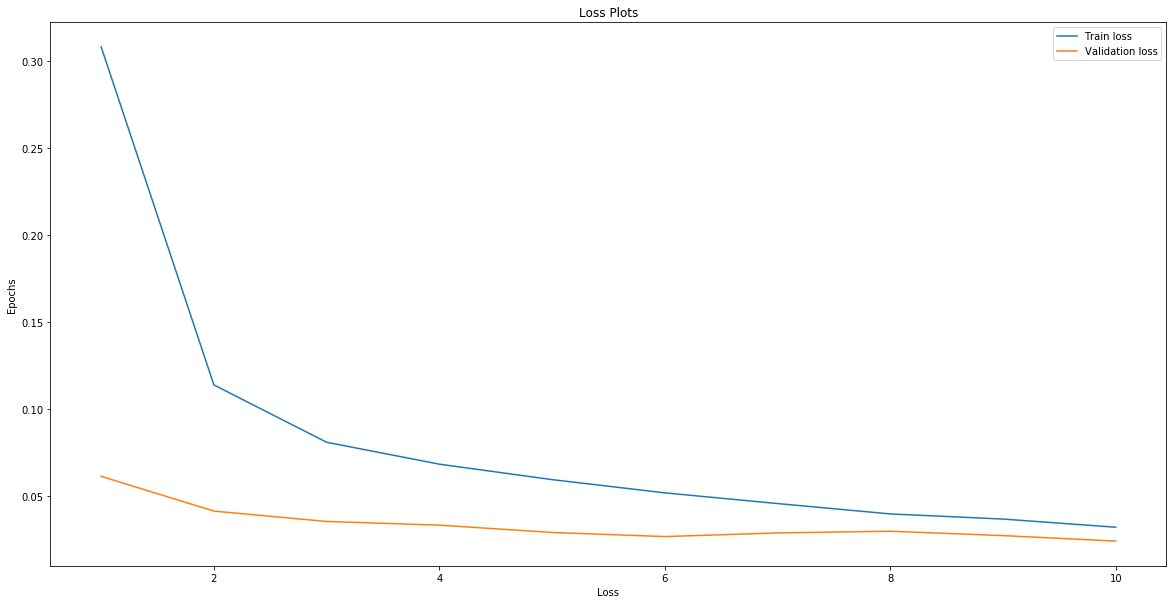

Test accuracy 31.03125000


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

<Figure size 1440x720 with 0 Axes>

In [8]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
#from model import Model
import numpy as np




# Downloading Datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))


# splitting datasets 
mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])


# Batch size is a term used in machine learning and refers to the number of training examples utilized in one iteration. 

"""
A batch size of 32 means that 32 samples from the training dataset will be used to estimate the error gradient 
before the model weights are updated. One training epoch means that the learning algorithm has made one pass through 
the training dataset, where examples were separated into randomly selected “batch size” groups.


"""

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))



# visualize data
fig = plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred


model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if (torch.cuda.is_available()):
    model.cuda()

no_epochs = 10
train_loss = list()
val_loss = list()
best_val_loss = 1


for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

            
        # optimizing gradients to zero before training 
        
        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    
    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()



# testing  model
model.load_state_dict(torch.load("model.dth"))
model.eval()

results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / (itr + 1)
print('Test accuracy {:.8f}'.format(test_accuracy))



# visualize results
fig = plt.figure(figsize=(20, 10))
for i in range(1, 10):
    img = transforms.ToPILImage(mode='L')(results[i][0].squeeze(0).detach().cpu())
    fig.add_subplot(2, 5, i)
    plt.title(results[i][1].item())
    plt.imshow(img)
plt.show()
